# Classification of Astronomical Objects with Tabular Data

The aim of this notebook is to correctly classify three types of astronomical objects (stars, galaxies, and quasars) with tabular data. We examine the data and its features; one of these features, namely redshift, plays an important role in determining the calssifiation due to properties of the universe that will be expanded upon (please excuse the pun) later in the notebook. As for the models, we first use the optimal neural network given a certain set/range of hyperparameters, which achieves ≈ 97% accuracy, and then we use a random forest, which achieves 98% accuracy and takes significantly less training time to do so.

## Set Up

In [1]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import reciprocal

from keras.models import Sequential
from keras.layers import Dense, Softmax, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

2023-03-23 17:50:18.959538: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 17:50:19.492860: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-23 17:50:19.492949: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-23 17:50:21.641700: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7:

In [2]:
df = pd.read_csv("star_classification.csv")

## Initial Exploratory Data Analysis

In [3]:
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [5]:
df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


## Some Minor Data Cleaning

In [6]:
df.isnull().sum()
# no missing values, which is good

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

In [7]:
(df==-9999).sum()

obj_ID         0
alpha          0
delta          0
u              1
g              1
r              0
i              0
z              1
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

In [8]:
undefined1 = df.loc[df['u'] == -9999]
undefined1

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
79543,1.237649e+18,224.006526,-0.624304,-9999.0,-9999.0,18.1656,18.01675,-9999.0,752,301,2,537,3.731277e+18,STAR,0.000089,3314,54970,162


In [9]:
undefined2 = df.loc[df['g'] == -9999]
undefined2

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
79543,1.237649e+18,224.006526,-0.624304,-9999.0,-9999.0,18.1656,18.01675,-9999.0,752,301,2,537,3.731277e+18,STAR,0.000089,3314,54970,162


In [10]:
undefined3 = df.loc[df['z'] == -9999]
undefined3

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
79543,1.237649e+18,224.006526,-0.624304,-9999.0,-9999.0,18.1656,18.01675,-9999.0,752,301,2,537,3.731277e+18,STAR,0.000089,3314,54970,162


In [11]:
# they all belong to the same row of index 79543, so we can just drop this row

df = df.drop(df.index[79543], axis=0)
df.shape

(99999, 18)

In [12]:
(df==-9999).sum()

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

In [13]:
df = df.reset_index(drop = True)

## Looking at the Classes

In [14]:
df['class'].value_counts()

GALAXY    59445
STAR      21593
QSO       18961
Name: class, dtype: int64

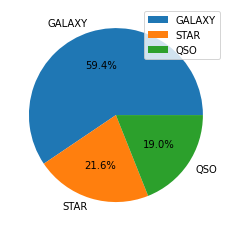

In [15]:
plt.pie(df['class'].value_counts(),autopct="%1.1f%%",labels=['GALAXY','STAR','QSO'])
plt.legend();

## Analyzing the Features

In [16]:
df_feat_imp = df.copy()

df_feat_imp["class"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in df["class"]]

X_feat_imp = df_feat_imp.drop(['class'], axis = 1)
y_feat_imp = df_feat_imp[['class']]

([<matplotlib.axis.XTick at 0x7fcbf4a9c9a0>,
 [Text(0, 0, 'obj_ID'),
  Text(1, 0, 'alpha'),
  Text(2, 0, 'delta'),
  Text(3, 0, 'u'),
  Text(4, 0, 'g'),
  Text(5, 0, 'r'),
  Text(6, 0, 'i'),
  Text(7, 0, 'z'),
  Text(8, 0, 'run_ID'),
  Text(9, 0, 'rerun_ID'),
  Text(10, 0, 'cam_col'),
  Text(11, 0, 'field_ID'),
  Text(12, 0, 'spec_obj_ID'),
  Text(13, 0, 'redshift'),
  Text(14, 0, 'plate'),
  Text(15, 0, 'MJD'),
  Text(16, 0, 'fiber_ID')])

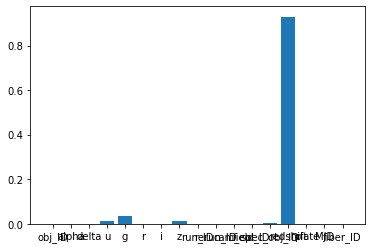

In [17]:
# GradientBoosting Features Importance
gb = GradientBoostingRegressor(n_estimators=100)
gb.fit(X_feat_imp, y_feat_imp.values.ravel())
plt.bar(range(X_feat_imp.shape[1]), gb.feature_importances_)
plt.xticks(range(X_feat_imp.shape[1]), X_feat_imp.columns.values.tolist())

In [18]:
corr = df_feat_imp.corr()
corr["class"].sort_values()

u             -0.226930
g             -0.066894
field_ID      -0.038057
run_ID        -0.000039
obj_ID        -0.000038
alpha          0.004549
cam_col        0.014481
fiber_ID       0.032059
delta          0.056650
r              0.150696
MJD            0.207264
spec_obj_ID    0.215726
plate          0.215726
i              0.284400
z              0.340914
redshift       0.536829
class          1.000000
rerun_ID            NaN
Name: class, dtype: float64

In [19]:
# Looking at the two previous cell outputs, we can:
# drop: field_ID, run_ID, obj_ID, alpha, cam_col, fiber_ID, delta, rerun_ID
# keep: u, g, z, r, MJD, spec_obj_ID, plate, i, redshift

df = df.drop(['obj_ID','alpha','delta','run_ID','rerun_ID','cam_col','field_ID','fiber_ID'], axis = 1)

## Understanding the Physics Behind the Feature Importance of Redshift

It can be seen that redshift is the most important feature in classifying the data, which makes sense, as we would expect quasars to have the highest redshift, followed by galaxies, and finally stars.

For context and further reasoning behind this, redshift indicates how an astronomical object moves compared to the observer, which in this case would be us on Earth. The redshift of an object is caused by the Doppler effect, which occurs when the object is moving away from us. The farther away an object, the faster it is receding from us due to the nature of the universe's expansion. Due to this property, a greater distance for light to travel results in increased cosmic expansion and wavelength stretching, leading to a higher level of redshift.

The farther away an object, the older its light is (but not necessarily the object itself) and the younger it appears in its own lifetime due to the increased duration of light travel. Quasars are believed to be the centers of galaxies in their infancy, so it makes sense that quasars are farther away (and therefore have a higher redshift) because they occurred when the universe was young, and we are able to still see them as such because it takes billions of years for that light to reach us. In other words, the farther away we look into space, the farther back we look in time.

Going back to our data, the same redshift principle applies in explaining why distant galaxies have a higher redshift than the stars that we observe in our own galaxy.

This concept can be visualized by looking at the variations in the other features with respect to redshift:

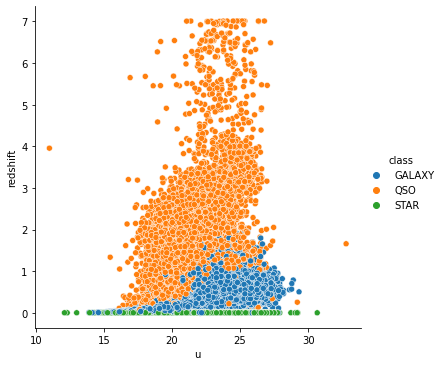

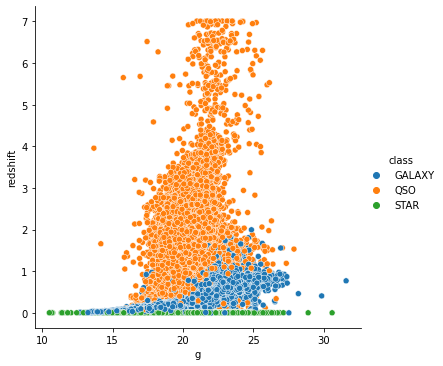

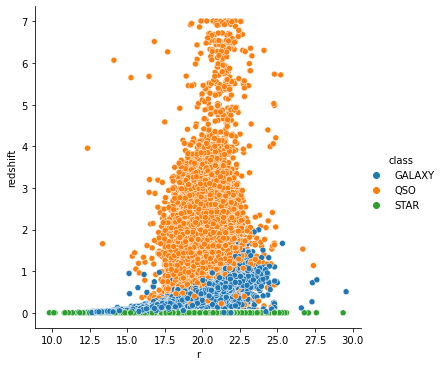

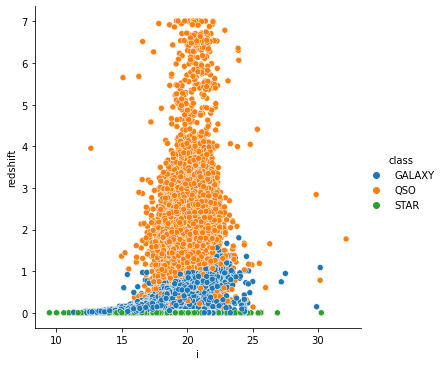

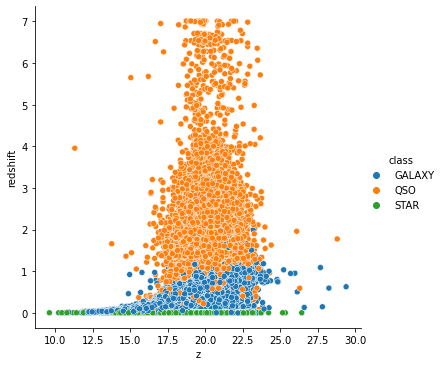

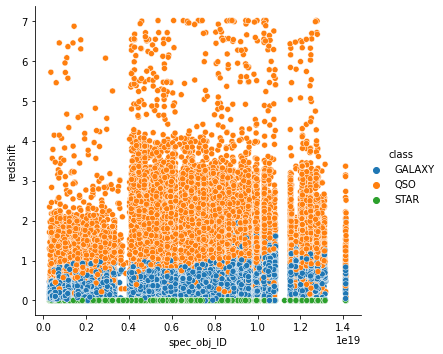

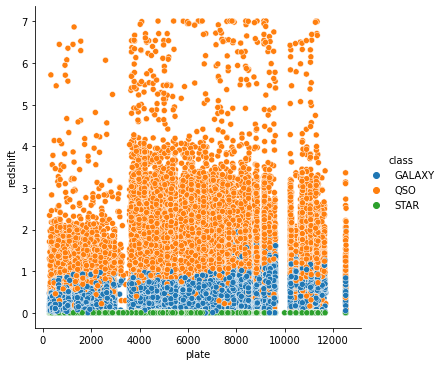

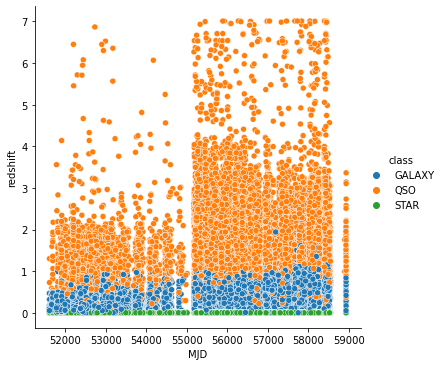

In [20]:
plots=[]
for i in [i for i in df.columns.values.tolist() if i not in ['class','redshift']]:
    g=sns.relplot(data=df,x=i, y='redshift', hue='class')
    plots.append(g);
    
    

## One-hot Encoding

In [21]:
df_1hot = df.copy()

one_hot = pd.get_dummies(df_1hot['class'])

df_1hot = pd.concat([df_1hot,one_hot],axis=1)
df_1hot = df_1hot.drop(['class'],axis=1)

In [22]:
df_1hot.head()

,u,g,r,i,z,spec_obj_ID,redshift,plate,MJD,GALAXY,QSO,STAR
0,23.87882,22.27530,20.39501,19.16573,18.79371,6.543777e+18,0.634794,5812,56354,1,0,0
1,24.77759,22.83188,22.58444,21.16812,21.61427,1.176014e+19,0.779136,10445,58158,1,0,0
2,25.26307,22.66389,20.60976,19.34857,18.94827,5.152200e+18,0.644195,4576,55592,1,0,0
3,22.13682,23.77656,21.61162,20.50454,19.25010,1.030107e+19,0.932346,9149,58039,1,0,0
4,19.43718,17.58028,16.49747,15.97711,15.54461,6.891865e+18,0.116123,6121,56187,1,0,0


In [23]:
X = df_1hot.drop(['GALAXY','QSO','STAR'], axis = 1)
y = df_1hot[['GALAXY','QSO','STAR']]

## Splitting

In [ ]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=0.8, random_state=42**2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42*2)

## Scaling

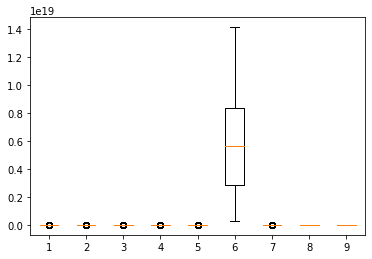

In [24]:
plt.boxplot(X)
plt.show()

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Modeling

In [29]:
def nn_model(n_hidden=1, n_neurons=30, learning_rate=0.01):
    model = Sequential()
    model.add(InputLayer(input_shape=(9,)))
    for i in range(n_hidden):
        model.add(Dense(n_neurons,activation='relu'))
        model.add(Dropout(0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(Adam(lr=learning_rate),'categorical_crossentropy', metrics=['accuracy'])
    return model

In [30]:
estimator = KerasClassifier(nn_model)

param_distributions = {
    'n_hidden': [0,1],
    'n_neurons': np.arange(1,50),
    'learning_rate': reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(estimator, param_distributions, n_iter=10, cv=3)
rnd_search_cv.fit(X_train,y_train, epochs=100, validation_data=(X_val,y_val),
                 callbacks=[EarlyStopping(patience=5)])

2023-03-23 17:52:22.759555: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-23 17:52:22.759859: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-23 17:52:22.760068: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-23 17:52:22.760259: W tensorflow/compiler/xla/stream_executor/platform/defa

Epoch 1/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3892 - accuracy: 0.8629 - val_loss: 0.2231 - val_accuracy: 0.9315
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2239 - accuracy: 0.9270 - val_loss: 0.1748 - val_accuracy: 0.9501
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1886 - accuracy: 0.9415 - val_loss: 0.1537 - val_accuracy: 0.9551
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1717 - accuracy: 0.9486 - val_loss: 0.1453 - val_accuracy: 0.9556
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1588 - accuracy: 0.9520 - val_loss: 0.1351 - val_accuracy: 0.9616
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1530 - accuracy: 0.9545 - val_loss: 0.1299 - val_accuracy: 0.9636
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1475 - accuracy: 0.9562 - val_loss: 0.1246 - val_ac

Epoch 1/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.4442 - accuracy: 0.8357 - val_loss: 0.2508 - val_accuracy: 0.9200
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2414 - accuracy: 0.9217 - val_loss: 0.1805 - val_accuracy: 0.9477
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1957 - accuracy: 0.9392 - val_loss: 0.1577 - val_accuracy: 0.9537
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1755 - accuracy: 0.9454 - val_loss: 0.1455 - val_accuracy: 0.9565
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1606 - accuracy: 0.9509 - val_loss: 0.1363 - val_accuracy: 0.9603
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1537 - accuracy: 0.9547 - val_loss: 0.1314 - val_accuracy: 0.9625
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1467 - accuracy: 0.9564 - val_loss: 0.1270 - val_ac

Epoch 1/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.4215 - accuracy: 0.8462 - val_loss: 0.2387 - val_accuracy: 0.9229
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2340 - accuracy: 0.9250 - val_loss: 0.1818 - val_accuracy: 0.9431
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1979 - accuracy: 0.9379 - val_loss: 0.1618 - val_accuracy: 0.9536
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1762 - accuracy: 0.9461 - val_loss: 0.1486 - val_accuracy: 0.9562
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1624 - accuracy: 0.9514 - val_loss: 0.1400 - val_accuracy: 0.9589
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1543 - accuracy: 0.9541 - val_loss: 0.1330 - val_accuracy: 0.9613
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1469 - accuracy: 0.9559 - val_loss: 0.1260 - val_ac

Epoch 1/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.6303 - accuracy: 0.7940 - val_loss: 0.4648 - val_accuracy: 0.8419
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.4240 - accuracy: 0.8575 - val_loss: 0.3883 - val_accuracy: 0.8714
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3673 - accuracy: 0.8769 - val_loss: 0.3457 - val_accuracy: 0.8909
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3317 - accuracy: 0.8943 - val_loss: 0.3168 - val_accuracy: 0.9026
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3079 - accuracy: 0.9062 - val_loss: 0.2972 - val_accuracy: 0.9103
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2909 - accuracy: 0.9132 - val_loss: 0.2827 - val_accuracy: 0.9167
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2785 - accuracy: 0.9187 - val_loss: 0.2722 - val_ac

Epoch 1/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.7265 - accuracy: 0.7018 - val_loss: 0.4923 - val_accuracy: 0.8449
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.4403 - accuracy: 0.8592 - val_loss: 0.3962 - val_accuracy: 0.8725
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3732 - accuracy: 0.8762 - val_loss: 0.3479 - val_accuracy: 0.8858
Epoch 4/100
1667/1667 [==============================] - 2s 1ms/step - loss: 0.3344 - accuracy: 0.8936 - val_loss: 0.3178 - val_accuracy: 0.9002
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3095 - accuracy: 0.9051 - val_loss: 0.2976 - val_accuracy: 0.9098
Epoch 6/100
1667/1667 [==============================] - 2s 1ms/step - loss: 0.2920 - accuracy: 0.9123 - val_loss: 0.2847 - val_accuracy: 0.9160
Epoch 7/100
1667/1667 [==============================] - 2s 1ms/step - loss: 0.2793 - accuracy: 0.9181 - val_loss: 0.2727 - val_ac

Epoch 1/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.6348 - accuracy: 0.7739 - val_loss: 0.4823 - val_accuracy: 0.8599
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.4369 - accuracy: 0.8603 - val_loss: 0.3969 - val_accuracy: 0.8726
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3740 - accuracy: 0.8758 - val_loss: 0.3499 - val_accuracy: 0.8859
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3356 - accuracy: 0.8933 - val_loss: 0.3196 - val_accuracy: 0.9009
Epoch 5/100
1667/1667 [==============================] - 2s 1ms/step - loss: 0.3101 - accuracy: 0.9053 - val_loss: 0.2987 - val_accuracy: 0.9096
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2923 - accuracy: 0.9124 - val_loss: 0.2838 - val_accuracy: 0.9134
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2792 - accuracy: 0.9176 - val_loss: 0.2735 - val_ac

Epoch 1/100
1667/1667 [==============================] - 4s 2ms/step - loss: 0.5052 - accuracy: 0.7997 - val_loss: 0.2803 - val_accuracy: 0.9075
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2988 - accuracy: 0.8934 - val_loss: 0.2131 - val_accuracy: 0.9427
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2442 - accuracy: 0.9174 - val_loss: 0.1811 - val_accuracy: 0.9492
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2192 - accuracy: 0.9298 - val_loss: 0.1663 - val_accuracy: 0.9538
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2036 - accuracy: 0.9370 - val_loss: 0.1571 - val_accuracy: 0.9536
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1943 - accuracy: 0.9402 - val_loss: 0.1501 - val_accuracy: 0.9572
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1853 - accuracy: 0.9423 - val_loss: 0.1435 - val_ac

Epoch 1/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.5885 - accuracy: 0.7853 - val_loss: 0.3515 - val_accuracy: 0.8754
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3468 - accuracy: 0.8741 - val_loss: 0.2390 - val_accuracy: 0.9297
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2788 - accuracy: 0.9018 - val_loss: 0.1999 - val_accuracy: 0.9441
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2412 - accuracy: 0.9188 - val_loss: 0.1772 - val_accuracy: 0.9493
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2166 - accuracy: 0.9280 - val_loss: 0.1642 - val_accuracy: 0.9526
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2010 - accuracy: 0.9345 - val_loss: 0.1512 - val_accuracy: 0.9544
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1918 - accuracy: 0.9384 - val_loss: 0.1433 - val_ac

Epoch 1/100
1667/1667 [==============================] - 4s 2ms/step - loss: 0.5982 - accuracy: 0.7673 - val_loss: 0.3231 - val_accuracy: 0.8918
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3417 - accuracy: 0.8754 - val_loss: 0.2446 - val_accuracy: 0.9268
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2870 - accuracy: 0.8981 - val_loss: 0.2127 - val_accuracy: 0.9378
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2544 - accuracy: 0.9115 - val_loss: 0.1921 - val_accuracy: 0.9443
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2254 - accuracy: 0.9249 - val_loss: 0.1685 - val_accuracy: 0.9501
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2096 - accuracy: 0.9321 - val_loss: 0.1557 - val_accuracy: 0.9562
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1982 - accuracy: 0.9377 - val_loss: 0.1466 - val_ac

Epoch 1/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.6256 - accuracy: 0.7843 - val_loss: 0.4783 - val_accuracy: 0.8505
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.4310 - accuracy: 0.8584 - val_loss: 0.3926 - val_accuracy: 0.8745
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3686 - accuracy: 0.8764 - val_loss: 0.3458 - val_accuracy: 0.8894
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3317 - accuracy: 0.8944 - val_loss: 0.3173 - val_accuracy: 0.9018
Epoch 5/100
1667/1667 [==============================] - 2s 1ms/step - loss: 0.3077 - accuracy: 0.9056 - val_loss: 0.2969 - val_accuracy: 0.9088
Epoch 6/100
1667/1667 [==============================] - 2s 1ms/step - loss: 0.2910 - accuracy: 0.9123 - val_loss: 0.2832 - val_accuracy: 0.9144
Epoch 7/100
1667/1667 [==============================] - 2s 1ms/step - loss: 0.2789 - accuracy: 0.9169 - val_loss: 0.2729 - val_ac

Epoch 1/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.7542 - accuracy: 0.6855 - val_loss: 0.4719 - val_accuracy: 0.8482
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.4224 - accuracy: 0.8645 - val_loss: 0.3794 - val_accuracy: 0.8744
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3586 - accuracy: 0.8828 - val_loss: 0.3357 - val_accuracy: 0.8929
Epoch 4/100
1667/1667 [==============================] - 2s 1ms/step - loss: 0.3238 - accuracy: 0.9001 - val_loss: 0.3091 - val_accuracy: 0.9069
Epoch 5/100
1667/1667 [==============================] - 2s 1ms/step - loss: 0.3013 - accuracy: 0.9093 - val_loss: 0.2918 - val_accuracy: 0.9146
Epoch 6/100
1667/1667 [==============================] - 2s 1ms/step - loss: 0.2860 - accuracy: 0.9170 - val_loss: 0.2782 - val_accuracy: 0.9179
Epoch 7/100
1667/1667 [==============================] - 2s 1ms/step - loss: 0.2745 - accuracy: 0.9214 - val_loss: 0.2693 - val_ac

Epoch 1/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.6366 - accuracy: 0.7726 - val_loss: 0.4883 - val_accuracy: 0.8420
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.4388 - accuracy: 0.8544 - val_loss: 0.3965 - val_accuracy: 0.8723
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3719 - accuracy: 0.8755 - val_loss: 0.3489 - val_accuracy: 0.8898
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3335 - accuracy: 0.8938 - val_loss: 0.3179 - val_accuracy: 0.8999
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3086 - accuracy: 0.9050 - val_loss: 0.2981 - val_accuracy: 0.9109
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2915 - accuracy: 0.9130 - val_loss: 0.2838 - val_accuracy: 0.9160
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2791 - accuracy: 0.9182 - val_loss: 0.2727 - val_ac

Epoch 1/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.5844 - accuracy: 0.8141 - val_loss: 0.4574 - val_accuracy: 0.8578
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.4185 - accuracy: 0.8626 - val_loss: 0.3815 - val_accuracy: 0.8775
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3616 - accuracy: 0.8815 - val_loss: 0.3393 - val_accuracy: 0.8949
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3275 - accuracy: 0.8969 - val_loss: 0.3122 - val_accuracy: 0.9052
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3048 - accuracy: 0.9081 - val_loss: 0.2936 - val_accuracy: 0.9122
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2887 - accuracy: 0.9140 - val_loss: 0.2810 - val_accuracy: 0.9206
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2769 - accuracy: 0.9196 - val_loss: 0.2700 - val_ac

Epoch 1/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.6517 - accuracy: 0.7476 - val_loss: 0.4755 - val_accuracy: 0.8393
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.4305 - accuracy: 0.8537 - val_loss: 0.3899 - val_accuracy: 0.8720
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3682 - accuracy: 0.8780 - val_loss: 0.3442 - val_accuracy: 0.8874
Epoch 4/100
1667/1667 [==============================] - 2s 1ms/step - loss: 0.3314 - accuracy: 0.8953 - val_loss: 0.3167 - val_accuracy: 0.9058
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3073 - accuracy: 0.9081 - val_loss: 0.2960 - val_accuracy: 0.9112
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2905 - accuracy: 0.9145 - val_loss: 0.2837 - val_accuracy: 0.9204
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2782 - accuracy: 0.9205 - val_loss: 0.2717 - val_ac

Epoch 1/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.7414 - accuracy: 0.7172 - val_loss: 0.5061 - val_accuracy: 0.8360
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.4541 - accuracy: 0.8501 - val_loss: 0.4110 - val_accuracy: 0.8641
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3848 - accuracy: 0.8691 - val_loss: 0.3605 - val_accuracy: 0.8844
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3430 - accuracy: 0.8881 - val_loss: 0.3270 - val_accuracy: 0.8985
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3152 - accuracy: 0.9007 - val_loss: 0.3050 - val_accuracy: 0.9076
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2965 - accuracy: 0.9093 - val_loss: 0.2891 - val_accuracy: 0.9133
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2831 - accuracy: 0.9146 - val_loss: 0.2770 - val_ac

Epoch 1/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.5060 - accuracy: 0.8104 - val_loss: 0.2713 - val_accuracy: 0.9184
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2788 - accuracy: 0.9033 - val_loss: 0.2027 - val_accuracy: 0.9411
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2332 - accuracy: 0.9235 - val_loss: 0.1798 - val_accuracy: 0.9486
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2075 - accuracy: 0.9348 - val_loss: 0.1607 - val_accuracy: 0.9563
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1897 - accuracy: 0.9418 - val_loss: 0.1504 - val_accuracy: 0.9584
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1788 - accuracy: 0.9462 - val_loss: 0.1429 - val_accuracy: 0.9595
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1703 - accuracy: 0.9488 - val_loss: 0.1372 - val_ac

Epoch 1/100
1667/1667 [==============================] - 4s 2ms/step - loss: 0.5189 - accuracy: 0.7943 - val_loss: 0.2750 - val_accuracy: 0.9149
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2811 - accuracy: 0.9020 - val_loss: 0.2038 - val_accuracy: 0.9405
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2288 - accuracy: 0.9267 - val_loss: 0.1752 - val_accuracy: 0.9488
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2035 - accuracy: 0.9356 - val_loss: 0.1599 - val_accuracy: 0.9534
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1870 - accuracy: 0.9425 - val_loss: 0.1489 - val_accuracy: 0.9564
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1755 - accuracy: 0.9467 - val_loss: 0.1415 - val_accuracy: 0.9586
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1685 - accuracy: 0.9491 - val_loss: 0.1372 - val_ac

Epoch 1/100
1667/1667 [==============================] - 4s 2ms/step - loss: 0.4963 - accuracy: 0.8172 - val_loss: 0.2912 - val_accuracy: 0.9071
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2917 - accuracy: 0.8997 - val_loss: 0.2096 - val_accuracy: 0.9408
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2322 - accuracy: 0.9231 - val_loss: 0.1782 - val_accuracy: 0.9491
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2036 - accuracy: 0.9353 - val_loss: 0.1567 - val_accuracy: 0.9543
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1861 - accuracy: 0.9422 - val_loss: 0.1525 - val_accuracy: 0.9519
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1762 - accuracy: 0.9454 - val_loss: 0.1419 - val_accuracy: 0.9593
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1686 - accuracy: 0.9497 - val_loss: 0.1348 - val_ac

Epoch 1/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3800 - accuracy: 0.8662 - val_loss: 0.2110 - val_accuracy: 0.9350
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2152 - accuracy: 0.9312 - val_loss: 0.1709 - val_accuracy: 0.9474
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1828 - accuracy: 0.9429 - val_loss: 0.1538 - val_accuracy: 0.9556
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1680 - accuracy: 0.9487 - val_loss: 0.1423 - val_accuracy: 0.9607
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1580 - accuracy: 0.9527 - val_loss: 0.1383 - val_accuracy: 0.9570
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1500 - accuracy: 0.9553 - val_loss: 0.1292 - val_accuracy: 0.9627
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1448 - accuracy: 0.9573 - val_loss: 0.1245 - val_ac

Epoch 1/100
1667/1667 [==============================] - 4s 2ms/step - loss: 0.3947 - accuracy: 0.8577 - val_loss: 0.2176 - val_accuracy: 0.9349
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2167 - accuracy: 0.9304 - val_loss: 0.1750 - val_accuracy: 0.9425
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1832 - accuracy: 0.9436 - val_loss: 0.1521 - val_accuracy: 0.9563
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1658 - accuracy: 0.9491 - val_loss: 0.1400 - val_accuracy: 0.9581
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1560 - accuracy: 0.9534 - val_loss: 0.1341 - val_accuracy: 0.9621
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1489 - accuracy: 0.9557 - val_loss: 0.1282 - val_accuracy: 0.9638
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1443 - accuracy: 0.9571 - val_loss: 0.1231 - val_ac

Epoch 1/100
1667/1667 [==============================] - 4s 2ms/step - loss: 0.3934 - accuracy: 0.8604 - val_loss: 0.2203 - val_accuracy: 0.9300
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2161 - accuracy: 0.9292 - val_loss: 0.1713 - val_accuracy: 0.9493
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1843 - accuracy: 0.9419 - val_loss: 0.1555 - val_accuracy: 0.9516
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1662 - accuracy: 0.9493 - val_loss: 0.1413 - val_accuracy: 0.9589
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1576 - accuracy: 0.9532 - val_loss: 0.1336 - val_accuracy: 0.9602
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1484 - accuracy: 0.9556 - val_loss: 0.1320 - val_accuracy: 0.9590
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1436 - accuracy: 0.9571 - val_loss: 0.1228 - val_ac

Epoch 1/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.7296 - accuracy: 0.7172 - val_loss: 0.5069 - val_accuracy: 0.8306
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.4508 - accuracy: 0.8491 - val_loss: 0.4062 - val_accuracy: 0.8687
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3788 - accuracy: 0.8718 - val_loss: 0.3537 - val_accuracy: 0.8860
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3377 - accuracy: 0.8910 - val_loss: 0.3219 - val_accuracy: 0.9029
Epoch 5/100
1667/1667 [==============================] - 3s 1ms/step - loss: 0.3114 - accuracy: 0.9036 - val_loss: 0.3000 - val_accuracy: 0.9101
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2935 - accuracy: 0.9111 - val_loss: 0.2859 - val_accuracy: 0.9169
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2806 - accuracy: 0.9165 - val_loss: 0.2741 - val_ac

Epoch 1/100
1667/1667 [==============================] - 3s 1ms/step - loss: 0.6831 - accuracy: 0.7439 - val_loss: 0.4856 - val_accuracy: 0.8423
Epoch 2/100
1667/1667 [==============================] - 2s 1ms/step - loss: 0.4421 - accuracy: 0.8567 - val_loss: 0.3996 - val_accuracy: 0.8692
Epoch 3/100
1667/1667 [==============================] - 2s 1ms/step - loss: 0.3782 - accuracy: 0.8746 - val_loss: 0.3522 - val_accuracy: 0.8880
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3388 - accuracy: 0.8927 - val_loss: 0.3210 - val_accuracy: 0.9022
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3127 - accuracy: 0.9052 - val_loss: 0.2999 - val_accuracy: 0.9095
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2946 - accuracy: 0.9131 - val_loss: 0.2847 - val_accuracy: 0.9157
Epoch 7/100
1667/1667 [==============================] - 2s 1ms/step - loss: 0.2812 - accuracy: 0.9186 - val_loss: 0.2741 - val_ac

Epoch 1/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.7371 - accuracy: 0.7164 - val_loss: 0.4845 - val_accuracy: 0.8546
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.4384 - accuracy: 0.8582 - val_loss: 0.3993 - val_accuracy: 0.8705
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3765 - accuracy: 0.8746 - val_loss: 0.3530 - val_accuracy: 0.8868
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3382 - accuracy: 0.8921 - val_loss: 0.3232 - val_accuracy: 0.9028
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3120 - accuracy: 0.9042 - val_loss: 0.3020 - val_accuracy: 0.9113
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2941 - accuracy: 0.9120 - val_loss: 0.2858 - val_accuracy: 0.9123
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2810 - accuracy: 0.9177 - val_loss: 0.2751 - val_ac

Epoch 1/100
1667/1667 [==============================] - 4s 2ms/step - loss: 0.4489 - accuracy: 0.8273 - val_loss: 0.2379 - val_accuracy: 0.9260
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2416 - accuracy: 0.9202 - val_loss: 0.1818 - val_accuracy: 0.9443
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2017 - accuracy: 0.9369 - val_loss: 0.1600 - val_accuracy: 0.9532
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1801 - accuracy: 0.9439 - val_loss: 0.1476 - val_accuracy: 0.9564
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1667 - accuracy: 0.9488 - val_loss: 0.1403 - val_accuracy: 0.9582
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1567 - accuracy: 0.9525 - val_loss: 0.1330 - val_accuracy: 0.9609
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1516 - accuracy: 0.9553 - val_loss: 0.1306 - val_ac

Epoch 1/100
1667/1667 [==============================] - 4s 2ms/step - loss: 0.4308 - accuracy: 0.8417 - val_loss: 0.2401 - val_accuracy: 0.9214
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2380 - accuracy: 0.9216 - val_loss: 0.1849 - val_accuracy: 0.9382
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1971 - accuracy: 0.9377 - val_loss: 0.1580 - val_accuracy: 0.9505
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1763 - accuracy: 0.9459 - val_loss: 0.1498 - val_accuracy: 0.9522
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1641 - accuracy: 0.9519 - val_loss: 0.1366 - val_accuracy: 0.9606
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1551 - accuracy: 0.9539 - val_loss: 0.1331 - val_accuracy: 0.9595
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1489 - accuracy: 0.9557 - val_loss: 0.1285 - val_ac

Epoch 1/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.4504 - accuracy: 0.8294 - val_loss: 0.2366 - val_accuracy: 0.9281
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2363 - accuracy: 0.9224 - val_loss: 0.1841 - val_accuracy: 0.9464
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2003 - accuracy: 0.9361 - val_loss: 0.1605 - val_accuracy: 0.9530
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1791 - accuracy: 0.9440 - val_loss: 0.1466 - val_accuracy: 0.9581
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1671 - accuracy: 0.9488 - val_loss: 0.1399 - val_accuracy: 0.9581
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1582 - accuracy: 0.9526 - val_loss: 0.1328 - val_accuracy: 0.9607
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.1504 - accuracy: 0.9554 - val_loss: 0.1291 - val_ac

Epoch 1/100
1667/1667 [==============================] - 4s 2ms/step - loss: 0.6932 - accuracy: 0.7154 - val_loss: 0.4776 - val_accuracy: 0.8425
Epoch 2/100
1667/1667 [==============================] - 2s 1ms/step - loss: 0.4296 - accuracy: 0.8538 - val_loss: 0.3897 - val_accuracy: 0.8725
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3663 - accuracy: 0.8767 - val_loss: 0.3439 - val_accuracy: 0.8902
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3305 - accuracy: 0.8942 - val_loss: 0.3157 - val_accuracy: 0.9027
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3071 - accuracy: 0.9047 - val_loss: 0.2966 - val_accuracy: 0.9100
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2909 - accuracy: 0.9118 - val_loss: 0.2831 - val_accuracy: 0.9141
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2790 - accuracy: 0.9178 - val_loss: 0.2731 - val_ac

Epoch 1/100
1667/1667 [==============================] - 4s 2ms/step - loss: 0.7119 - accuracy: 0.7290 - val_loss: 0.5057 - val_accuracy: 0.8362
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.4564 - accuracy: 0.8510 - val_loss: 0.4130 - val_accuracy: 0.8609
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3883 - accuracy: 0.8695 - val_loss: 0.3624 - val_accuracy: 0.8795
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3463 - accuracy: 0.8884 - val_loss: 0.3285 - val_accuracy: 0.8975
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3181 - accuracy: 0.9022 - val_loss: 0.3058 - val_accuracy: 0.9067
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2986 - accuracy: 0.9102 - val_loss: 0.2895 - val_accuracy: 0.9098
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2844 - accuracy: 0.9161 - val_loss: 0.2774 - val_ac

Epoch 1/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.6995 - accuracy: 0.7403 - val_loss: 0.4867 - val_accuracy: 0.8450
Epoch 2/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.4365 - accuracy: 0.8552 - val_loss: 0.3977 - val_accuracy: 0.8719
Epoch 3/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3742 - accuracy: 0.8755 - val_loss: 0.3526 - val_accuracy: 0.8870
Epoch 4/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3368 - accuracy: 0.8922 - val_loss: 0.3218 - val_accuracy: 0.9011
Epoch 5/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.3114 - accuracy: 0.9042 - val_loss: 0.3006 - val_accuracy: 0.9090
Epoch 6/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2936 - accuracy: 0.9119 - val_loss: 0.2854 - val_accuracy: 0.9123
Epoch 7/100
1667/1667 [==============================] - 3s 2ms/step - loss: 0.2806 - accuracy: 0.9176 - val_loss: 0.2748 - val_ac

Epoch 1/100
2500/2500 [==============================] - 5s 2ms/step - loss: 0.3550 - accuracy: 0.8695 - val_loss: 0.1898 - val_accuracy: 0.9409
Epoch 2/100
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1933 - accuracy: 0.9388 - val_loss: 0.1525 - val_accuracy: 0.9546
Epoch 3/100
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1675 - accuracy: 0.9492 - val_loss: 0.1378 - val_accuracy: 0.9593
Epoch 4/100
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1542 - accuracy: 0.9537 - val_loss: 0.1278 - val_accuracy: 0.9634
Epoch 5/100
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1445 - accuracy: 0.9566 - val_loss: 0.1238 - val_accuracy: 0.9637
Epoch 6/100
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1391 - accuracy: 0.9584 - val_loss: 0.1207 - val_accuracy: 0.9653
Epoch 7/100
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1338 - accuracy: 0.9603 - val_loss: 0.1161 - val_ac

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fcbf476c3a0>,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcbf476cca0>,
                                        'n_hidden': [0, 1],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

## Finding the Optimal Model

In [31]:
rnd_search_cv.best_params_

{'learning_rate': 0.0015606339269526653, 'n_hidden': 1, 'n_neurons': 34}

In [32]:
rnd_search_cv.best_score_

0.9694371223449707

In [33]:
model = rnd_search_cv.best_estimator_.model

## Prediction Performance

In [34]:
pred = model.predict(X_test)

313/313 [==============================] - 0s 1ms/step


In [35]:
index_highest_prob=[]
for i in range(len(pred)):
    index_highest_prob.append(np.argmax(pred[i]))

In [36]:
print(y_test)
print(index_highest_prob)

       GALAXY  QSO  STAR
53043       0    1     0
29195       0    0     1
6473        0    1     0
80770       1    0     0
88596       0    1     0
...       ...  ...   ...
70240       1    0     0
96207       1    0     0
82527       1    0     0
69580       1    0     0
40681       1    0     0

[10000 rows x 3 columns]
[1, 2, 1, 0, 0, 2, 0, 0, 0, 2, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 2, 1, 0, 0, 0, 1, 0, 1, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 1, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 1, 2, 0, 1, 2, 0, 0, 0, 0, 0, 2, 2, 1, 1, 0, 0, 2, 1, 2, 0, 2, 0, 1, 0, 0, 2, 2, 2, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 2, 1, 0, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 1, 0, 2, 1, 0, 2, 1, 1, 1, 0, 0, 1, 1, 2, 2, 2, 1, 1, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 2, 2, 2, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0

In [37]:
len(y_test) == len(index_highest_prob)

True

In [38]:
pred = [[1, 0, 0] if i == 0 else [0, 1, 0] if i == 1 else [0, 0, 1] for i in index_highest_prob]

In [39]:
accuracy_score(y_test, pred)

0.9692

## Random Forest

Neural networks are not always necessary to achieve a desired performance. For instance, we can simply use a random forest, which outperforms the previous model and takes significantly less training time to do so.

In [40]:
X_train_rf = np.concatenate((X_train,X_val))
y_train_rf = np.concatenate((y_train,y_val))

In [52]:
rf = RandomForestClassifier()
rf.fit(X_train_rf,y_train_rf)
pred = rf.predict(X_test)
score = rf.score(X_test, y_test)
rf_score = np.mean(score)

print('Accuracy : %.3f' % (rf_score))

Accuracy : 0.980


In [56]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5843
           1       0.96      0.94      0.95      1942
           2       1.00      1.00      1.00      2215

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000
 samples avg       0.98      0.98      0.98     10000



## Resources

Dataset - https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17

Inspiration for pie chart and relational plot - https://www.kaggle.com/code/prasadposture121/stellar-classification

Code for NN - https://www.kaggle.com/code/sainathd/stellar-classification-nn

Code for GradientBoosting features importance - https://towardsdatascience.com/feature-importance-with-neural-network-346eb6205743